# Note to user
This project contains model tuning data that exceeds the upload size constrains of the Moodle server. The entire source code, including the Jupyter notebook and the tuning data can be downloaded at __https://github.com/junelsolis/AAU-Machine-Learning__

# Initial setup and data import

In [6]:
!pip install -q tweet-preprocessor nltk keras-tuner textblob ipywidgets swifter keras sklearn tensorflow tqdm pv autocorrect beautifulsoup4 lxml

In [7]:
# Make default library imports
import pandas as pd
import numpy as np
import preprocessor as p
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import swifter

tqdm.pandas()

plt.style.use('fivethirtyeight')

%matplotlib inline

In [8]:
# Read the data from file
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', delimiter='\t')
data.head()


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Null values present in labels: False
Null values present in tweet text: False



<BarContainer object of 2 artists>

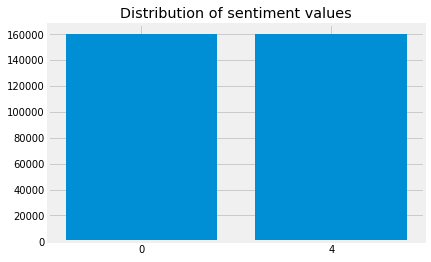

In [9]:
# Check for null values in the data
# Plot label histogram
print('Null values present in labels: ' + str(data['sentiment_label'].isnull().values.any()))
print('Null values present in tweet text: ' + str(data['tweet_text'].isnull().values.any()))
print()

plt.title('Distribution of sentiment values')
plt.bar(['0','4'], [len(data['sentiment_label'].where(data['sentiment_label'] == 0)), len(data['sentiment_label'].where(data['sentiment_label'] == 4))])


# Preprocess tweets

In [10]:
# Import NLTK dependencies
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/junelsolis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
from textblob import TextBlob, Word
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from bs4 import BeautifulSoup
from os import path
import swifter

### Text processing functions

In [12]:
def process_tweet(tweet):

  clean_tweet = tweet
  
  # Remove punctuations and numbers
  clean_tweet = re.sub('[^a-zA-Z]', ' ', clean_tweet)

  # Convert to lower case
  clean_tweet = clean_tweet.lower()

  # Single character removal
  clean_tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_tweet)

  # Removing multiple spaces
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)

  # Remove words longer than 41 chars
  clean_tweet_words = clean_tweet.split(' ')
  filter_max_word_length_tweet = []
  for w in clean_tweet_words:
    if (len(w) <= 40):
      filter_max_word_length_tweet.append(w)

  clean_tweet =  " ".join(filter_max_word_length_tweet)

  # Remove multiple spaces again
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)
  return clean_tweet


tag_dict = {"J": 'a', 
            "N": 'n', 
            "V": 'v', 
            "R": 'r'}

########################
########################
def lemmatize(tweet):
  blob = TextBlob(tweet)

  
  words_and_tags = [(Word(w), tag_dict.get(pos[0], 'n')) for w, pos in blob.tags]
  lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]

  return " ".join(lemmatized_list)


########################
########################
ps = PorterStemmer()

def stem(tweet):
  output = []
  for w in tweet.split():
      output.append("".join(ps.stem(w)))

  return " ".join(output)

########################
########################
def remove_stop_words(tweet):

  word_tokens = word_tokenize(tweet)  
  
  filtered_sentence = []  
    
  for w in word_tokens:  
      if w not in stop_words:  
          filtered_sentence.append(w)  

  return " ".join(filtered_sentence)

########################
########################
def correct_spelling(tweet):
  
    blob = TextBlob(tweet)
    return str(blob.correct())


########################
########################
def empty_single_word_tweets(tweet):
  if (len(tweet.split(' ')) > 1):
      return tweet
  else:
      return ''




## IMPORTANT ##
In this section, the tweet samples are preprocessed. As it takes a lot of time to do this, the pickled data has been saved to a file called __clean_data.pkl__

If this file exists in the project directoy, it is automatically loaded and used for the rest of the notebook. If refreshing the data is needed, then delete the __clean_data.pkl__ file and run the cell below. __Be advised:__ it will take at least half an hour on regular PC's.

In [13]:
# Drop tweets longer than 140 original characters
mask = data['tweet_text'].str.len() <= 140
data = data.loc[mask]

In [14]:
# Clean the tweets. 
# Remove the following:
# - URLS
# - Hashtags
# - Mentions
# - Reserved words (RT, FAV)
# - Emojis
# - Smileys
# - Numbers



if path.exists('clean_data.pkl'):
    clean_data = pd.read_pickle('clean_data.pkl')
    
else:


    # Copy the dataset and retain the original data
    clean_data = data.copy()
    clean_data = clean_data.sample(70000) # reduce number of samples

    # Convert labels to binary
    clean_data.loc[clean_data['sentiment_label'] == 4, 'sentiment_label'] = 1

    # Run initial clean with tweet-preprocessor
    print('Initial cleaning...\n')
    clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: p.clean(row))

    # Decode HTML
    print('Decoding HTML...')
    clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: BeautifulSoup(row, 'lxml').get_text())


    # Lemmatize
    # print('Lemmatizing...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: lemmatize(row))

    # Stemming
    # print('Stemming...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: stem(row))

    # Run more cleaning
    print('More cleaning...')
    clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: process_tweet(row))

    # Remove stop words
    # print('Remove stop words...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: remove_stop_words(row))

    # Correct spelling
    # speller = Speller()
    # print('Spelling check...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: speller(row))

    # Remove tweets with only a single word
    print('Remove single-word tweets...\n')
    clean_data['tweet_text'] = clean_data['tweet_text'].swifter.allow_dask_on_strings().apply(lambda row: empty_single_word_tweets(row))
    clean_data.drop(clean_data[clean_data['tweet_text'] == ''].index, inplace=True)



    # Save cleaned data to pickle and to csv
    clean_data.to_pickle('clean_data.pkl')
    clean_data.to_csv('clean_data.csv')




In [15]:
# Print random sample of cleaned tweets
print(clean_data.count())
clean_data.sample(15)

sentiment_label    69475
tweet_text         69475
dtype: int64


,sentiment_label,tweet_text
126257,1,hmm gymm in the morning
132545,1,hello hello myself marshal it is nice forum pr...
113507,1,the invogue empire is coming just wait more an...
81529,1,can join
129957,1,started off the first day of my th year riding...
59730,0,and climbing as of am today and of course you...
8870,0,so horny and missing my goddess
123118,1,just working on little asp net service for an ...
17981,0,very sorry to read that hope you all feel bett...
104814,1,yup you ve got me figured out lol and now so d...


# Support Vector Machine

## Prepare the dataset

In [16]:
# Split the dataset into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_data['tweet_text'], clean_data['sentiment_label'], test_size=0.2)

## Vectorize using TF-IDF

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(max_features=2000)
tf_idf_vect.fit(clean_data['tweet_text'])

X_train_tf_idf = tf_idf_vect.transform(X_train)
X_test_tf_idf = tf_idf_vect.transform(X_test)

def tf_idf_vectorizer(df):
    tf_idf_vect = TfidfVectorizer(max_features=2000)
    tf_idf_vect.fit(df['tweet_text'])

    return tf_idf_vect.transform(df['tweet_text'])


## Fit data to SVM

In [18]:
# load the model from file if already available
# otherwise fit the dataset

from sklearn import model_selection, svm
import pickle

if path.exists('models/svm_model/svm_model.pkl'):
    with open('models/svm_model/svm_model.pkl', 'rb') as file:
        svm_model = pickle.load(file)

else:
    # Classifier - Algorithm - SVM
    # fit the training dataset on the classifier
    svm_model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', verbose=True)
    svm_model.fit(X_train_tf_idf, y_train)

    with open('models/svm_model/svm_model.pkl', 'wb') as file:
        pickle.dump(svm_model, file)

## Measure accuracy

In [19]:
from sklearn.metrics import accuracy_score

# predict the labels on validation dataset
predictions_SVM = svm_model.predict(X_test_tf_idf)

# Use accuracy_score function to get the accuracy
svm_accuracy_score = accuracy_score(predictions_SVM, y_test) * 100
with open('svm_accuracy_score.txt', 'w') as file:
    file.write(str(svm_accuracy_score))
    
print("SVM Accuracy Score -> ", svm_accuracy_score)


SVM Accuracy Score ->  78.6613889888449


# LSTM Recurrent Neural Network Model

### Download and extract Stanford NLP GloVe
 - Do not download if the zip file already exists
 - Do not attempt extract if the __glove_data__ directory exists

In [20]:
import requests

if path.exists('glove.zip') == False:
    url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip" 
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open('glove.zip', 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

if path.exists('glove_data') == False:
    n_files = !unzip -l glove.zip | grep . | wc -l
    # !unzip -o ./glove.zip -d ./glove_data/ | pv -l -s {n_files[0]} > /dev/null
    !unzip -o ./glove.zip -d ./glove_data/ | pv -l -s {n_files[0]} > /dev/null

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Set maximum number of words and GloVe dimensions to use
NB_WORDS = 5000
GLOVE_DIM = 200

# Tokenize the text corpus
tokenizer = Tokenizer(num_words=NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', split=" ")
tokenizer.fit_on_texts(clean_data['tweet_text'].values)

X = tokenizer.texts_to_sequences(clean_data['tweet_text'].values)
X = pad_sequences(X) # add padding to text vector so they all have the same length

In [22]:

glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('glove_data/' + glove_file)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [23]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tokenizer.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [24]:
# Split the dataset into training and test
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, clean_data['sentiment_label'], test_size=0.2)

### Configure hyperparameter tuning

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

def build_model(hp):

    # variables to adjust during tuning
    hp_units_1 = hp.Int('units_1', min_value = 32, max_value = 512, step = 32)
    hp_units_2 = hp.Int('units_2', min_value = 32, max_value = 512, step = 32)
    # hp_lstm_1_dropout = 
    
    # define model
    model = Sequential()

    model.add(Embedding(NB_WORDS, GLOVE_DIM, input_length=X.shape[1]))
    model.layers[0].set_weights([emb_matrix])
    model.layers[0].trainable = False

    model.add(LSTM(hp_units_1, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2))
    model.add(LSTM(hp_units_2, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), metrics=['accuracy'])

    return model

### Hyperparameter tuning
This cell executes hyperparameter tuning. If you wish to execute the hyperparameter tuning again, please uncomment the __lstm_tuner.search()__ line below.

In [26]:
import kerastuner as kt
import tensorflow as tf
import IPython

lstm_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 5,
                     factor = 3,
                     directory = './',
                     project_name = 'lstm_tuning')


class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

####################################################################################
## Uncomment the line below in order to run additional hyperparameter tuning
####################################################################################
#lstm_tuner.search(X_train_lstm, y_train_lstm, epochs = 1, validation_split=0.3, callbacks = [ClearTrainingOutput()])

best_hyperparameters = lstm_tuner.get_best_hyperparameters(num_trials = 1)[0]


INFO:tensorflow:Reloading Oracle from existing project ./lstm_tuning/oracle.json
INFO:tensorflow:Reloading Tuner from ./lstm_tuning/tuner0.json


### Compile and train
Load and use the hyperparameter values gathered during tuning to build the actual model and save to disk as __lstm_model__

In [27]:
from keras.models import load_model
import pickle

# Compile and train model if it doesn't already exist
# Otherwise simply load the model from file
if path.exists('models/lstm_model'):
    lstm_model = load_model('models/lstm_model')
    with open('models/lstm_training_history', 'rb') as file:
        history = pickle.load(file)


else:
    lstm_model = lstm_tuner.hypermodel.build(best_hyperparameters)
    history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 5, validation_split=0.3)

    with open('models/lstm_training_history', 'wb') as history_file:
        pickle.dump(history.history, history_file)

    lstm_model.save('models/lstm_model')


In [28]:
from contextlib import redirect_stdout

# Print out the LSTM model summary 
lstm_model.summary()

# Save summary to file
with open('lstm_model_summary.txt', 'w') as file:
    with redirect_stdout(file):
        lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 200)           1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 31, 256)           467968    
_________________________________________________________________
lstm_1 (LSTM)                (None, 288)               627840    
_________________________________________________________________
dense (Dense)                (None, 2)                 578       
Total params: 2,096,386
Trainable params: 2,096,386
Non-trainable params: 0
_________________________________________________________________


In [29]:
evaluate = lstm_model.evaluate(X_test_lstm, y_test_lstm)

with open('lstm_accuracy.txt', 'w') as file:
    file.write(f"{evaluate[1] * 100}")

with open('lstm_loss.txt', 'w') as file:
    file.write(f"{evaluate[0]}")

435/435 [==============================] - 15s 33ms/step - loss: 0.3428 - accuracy: 0.8585


# Generate figures for report

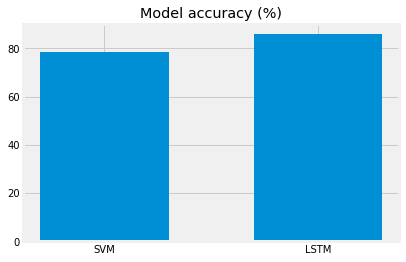

In [30]:
with open('svm_accuracy_score.txt', 'r') as file:
    SVM_ACCURACY = float(file.read())

with open('lstm_accuracy.txt', 'r') as file:
    LSTM_ACCURACY = float(file.read())

with open('lstm_loss.txt', 'r') as file:
    LSTM_LOSS = float(file.read())


# print(SVM_ACCURACY)
# print(LSTM_ACCURACY)
plt.title('Model accuracy (%)')
plt.bar(['SVM', 'LSTM'], [SVM_ACCURACY, LSTM_ACCURACY], width=0.6)
plt.savefig('model_accuracy.png')


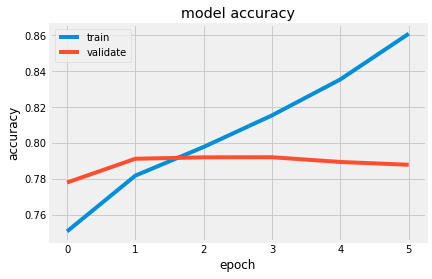

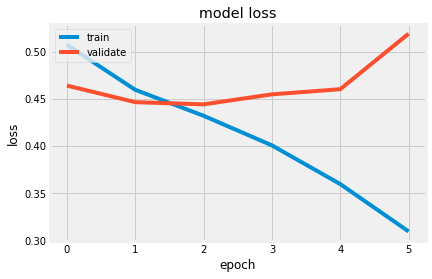

In [31]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('lstm_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('lstm_loss.png')
plt.show()

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup

# Add a function to clean a single tweet
def clean_single_tweet(tweet):
    tweet = process_tweet(tweet)
    tweet = BeautifulSoup(tweet, "lxml").get_text()

    return tweet

def tf_idf_vectorizer(df):
    df['tweet_text'] = df['tweet_text'].apply(lambda row: clean_single_tweet(row))
    return tf_idf_vect.transform(df['tweet_text'])

def lstm_tokenizer(df):
    df['tweet_text'] = df['tweet_text'].apply(lambda row: clean_single_tweet(row))
    X = tokenizer.texts_to_sequences(df['tweet_text'].values)
    X = pad_sequences(X) 

    return X

In [54]:


# Make some predictions on example tweets using the SVM and LSTM models
# The results of these predictions are presented in the report.

tweets = np.array([
    "Crazy Joe Biden is trying to act like a tough guy. Actually, he is weak, both mentally and physically, and yet he threatens me, for the second time, with physical assault. He doesn’t know me, but he would go down fast and hard, crying all the way. Don’t threaten people Joe!",
    "Sorry losers and haters, but my I.Q. is one of the highest -and you all know it! Please don’t feel so stupid or insecure,it’s not your fault",
    "President of the United States, husband to @DrBiden, proud father & grandfather. Ready to build back better for all Americans.",
    "No one is born hating another person because of the color of his skin or his background or his religion..."
    "It's been the honor of my life to serve you. You made me a better leader and a better man.",
    "I would love to climb the Matterhorn!"
])

test_data = pd.DataFrame(tweets, columns = ['tweet_text'])

svm_data = test_data.copy()
lstm_data = test_data.copy()

svm_predictions = svm_model.predict(tf_idf_vectorizer(svm_data))
lstm_predictions = lstm_model.predict(lstm_tokenizer(lstm_data))

print('SVM predictions:')
print(svm_predictions)
print()

print('LSTM predictions:')
print(lstm_predictions)


SVM predictions:
[0 0 1 1 1]

LSTM predictions:
[[0.9625721  0.03742785]
 [0.8038369  0.1961631 ]
 [0.06308108 0.9369189 ]
 [0.02888044 0.9711195 ]
 [0.04700107 0.9529989 ]]
